# Main programme avec interaction avec l'utilisateur



L'idée de ce dossier est de modéliser un CP avec interaction d'un décision-maker.

In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [2]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# Parameters

k = 20

# Interaction with the solver

data = []
file = './file_with_optimal_val/la03.txt'
optimalval = -1

with open(file, 'r') as f:    
    for line in f:
        if line.startswith('optimalval ='):
            line_splitted = line.strip().split('=')
            optimalval = int(line_splitted[1])
        else:
            data.append(line.strip().split())

n = int(data[0][0])
m = int(data[0][1])

T_machine = []
T_duration = []

for i in range(1,n+1):
    for j in range(0, 2*m, 2):
        T_machine.append(int(data[i][j]))
        T_duration.append(int(data[i][j+1]))

duration = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        ind_machine = int(T_machine[i*m + j])
        duration[i][ind_machine] = T_duration[i*m + j]


# --------- Call Solver constructor in Solver.py

solver = Solver(data)

model = CpoModel() 

# --------- Create the model variables 

solver.create_variables(model, n, m, duration)

# ------------ Solve the model

print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, T_machine, optimalval)

# ------------ Display the result

# for sol in msol:
#     sol.write()
print("Model solved !")


# ---------------- Interaction with the user

print("\n--------Interaction with the user...---------")

print("\nCreating the user...")
user = User()
print("User created !")

print("\nClassing solutions...")	
list_indice, list_equal, list_obj = user.classerSolutions(msol)
# print(list_obj)
print("Solutions classed !")

print("\nCreating preferences...")
pref = user.getPreferences()
print("Preferences created !")

print("\nDisplaying preferences...")
# for sol in pref:
#     sol.write()

# print("\nPreferences : ", pref)
# print(list_indice)
# print(list_equal)

variables = solver.get_variables()
matrix = user.matrix_pref(n, m, False)

pref = user.getPreferences()

print("\nTesting preferences...")

if user.test_preferences(pref):
    print("\tL'ordre des préférences est cohérente")
else:
    print("\tL'ordre des préférences n'est pas cohérente")
    
if user.test_differences_sol(matrix):
    print("\tToutes les solutions sont différentes")
else:
    print("\tLes solutions ne sont pas toutes différentes")



--------Main program is loading...---------

Solver initialized !

Creating the model variables...
Model variables created !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Solutions classed !

Creating preferences...
Preferences created !

Displaying preferences...

Testing preferences...
	L'ordre des préférences est cohérente
	Toutes les solutions sont différentes


In [3]:
###  -------------- Iteration of the solver with the preferences

# ----------------- Parameters

tps_max = 100
tps = runtime
it_max = 5
it = 1
k_k = 3

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model

while criterion :

    print("\n--------Iteration {}---------".format(it))

    it += 1
    
    solver = Solver(data)
    model = CpoModel() 

    # --------- Create the model variables 

    solver.create_variables(model, n, m, duration) 

    # stop = int(input("Do you want to continue ? True(1) or False(0)"))

    bb = integer_var(0,1)
    solver.add_variable(bb)
    bb=1

    list_variables = solver.get_variables()
    variables = list_variables[0]

    for sol in pref:
        b = integer_var(0,1)
        solver.add_variable(b)
        b=0

        for i in range(n):
            for j in range(m):

                var_sol = sol.get_value("T{}-{}".format(i,j))
                #a = model.interval_var(start = sol[variables[i][j]].start, end= sol[variables[i][j]].end, size=int(duration[i][j]), name="a{}{}".format(i,j))
                #b =max(b,logical_or((model.start_of(a) != model.start_of(variables[i][j])), (model.end_of(a) != model.end_of(variables[i][j]))))
                
                b =max(b,logical_or(var_sol.start != model.start_of(variables[i][j]), var_sol.end != model.end_of(variables[i][j])))
        b = (b!=0)
        bb = bb * b
    solver.add_constraint(bb==1)
    

# ------------ Solve the model

    print("\nSolving the model...")

    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval)

# ------------ Display the result

    # for sol in msol:
    #     sol.write()
    print("Model solved !")


# ---------------- Interaction with the user

    print("\n--------Interaction with the user...---------")

    print("\nClassing solutions...")	
    list_indice, list_equal, list_obj = user.classerSolutions(msol)
    print(list_obj)
    # print(list_indice)
    print(list_equal)
    # print(list_indice)
    print("Solutions classed !")

    print("\nCreating preferences...")
    pref = user.getPreferences()
    print("Preferences created !")

    print("\nDisplaying preferences...")
    # for sol in pref:
    #     sol.write()

    # print("\nPreferences : ", pref)
    # print(list_indice)
    # print(list_equal)
    # print(len(pref))

    starts = user.start_pref(n, m, variables, False)

    matrix = user.matrix_pref(n, m, False)
    # print(len(matrix))
    print("\nTesting preferences...")

    pref = user.getPreferences()
    
    if user.test_preferences(pref):
        print("\tL'ordre des préférences est cohérente")
    else:
        print("\tL'ordre des préférences n'est pas cohérente")
        
    if user.test_differences_sol(matrix):
        print("\tToutes les solutions sont différentes")
    else:
        print("\tLes solutions ne sont pas toutes différentes")

    tps += runtime

    criterion = (tps < tps_max) and (it < it_max)

    if (it == it_max):
        print("The user has reached the maximum number of iterations !")
    # elif not stop:
    #     print("The user has chosen his/her solution !")
    elif (tps >= tps_max):
        print("The user has reached the maximum time !")


print("\n--------End of the interaction with the user...---------")


--------Iteration 1---------

Solver initialized !

Creating the model variables...
Model variables created !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Classing solutions...
[696, 735, 696, 696, 696, 696, 696, 696, 696, 696, 699, 701, 702, 702, 702, 702, 717, 726, 728, 734, 735, 746, 777]
[True, True, True, True, True, True, True, True, False, False, False, True, True, True, False, False, False, False, False, True, False, False]
Solutions classed !

Creating preferences...
Preferences created !

Displaying preferences...

Testing preferences...
	L'ordre des préférences est cohérente
	Toutes les solutions sont différentes

--------Iteration 2---------

Solver initialized !

Creating the model variables...
Model variables created !

Solving the model...

Adding precedence constraints to 

In [4]:
#Clustering des solutions
import clustering as cl

layers = cl.create_layers(list_equal, matrix)
print(layers)
print(len(layers))


Clustering ...
[[[302, 0, 38, 611, 384, 384, 124, 103, 561, 468, 525, 644, 0, 38, 295, 160, 394, 214, 504, 81, 214, 333, 496, 394, 118, 81, 160, 288, 377, 0, 434, 578, 83, 0, 525, 402, 249, 441, 496, 175, 295, 539, 377, 302, 199, 577, 456, 596, 649, 255], [302, 0, 38, 527, 384, 384, 124, 103, 565, 468, 558, 644, 0, 38, 295, 160, 394, 214, 462, 81, 214, 333, 496, 394, 118, 81, 160, 288, 377, 0, 434, 578, 83, 0, 525, 402, 249, 441, 519, 175, 295, 539, 377, 302, 199, 539, 456, 558, 615, 255], [302, 0, 38, 519, 384, 384, 124, 103, 565, 468, 402, 578, 0, 38, 295, 160, 394, 214, 462, 81, 214, 333, 541, 394, 118, 81, 160, 288, 377, 0, 486, 630, 83, 0, 577, 454, 249, 486, 557, 175, 295, 539, 377, 302, 199, 577, 456, 596, 615, 255], [302, 0, 38, 559, 384, 384, 124, 103, 509, 468, 525, 578, 0, 38, 295, 160, 394, 214, 597, 81, 214, 333, 496, 394, 118, 81, 160, 288, 377, 0, 434, 630, 83, 0, 525, 402, 249, 441, 496, 175, 295, 539, 377, 302, 199, 577, 456, 596, 654, 255], [302, 0, 38, 619, 384, 384,

-------------- Layer 0 -----------------


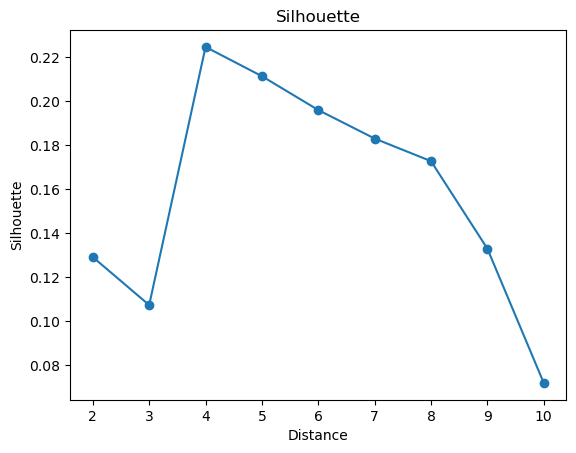

D'après l'indice de silhouette, nb clusters = 4 , nb feuilles =  11  runtime =  0.0 s 

-------------- Layer 1 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 2 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 3 -----------------


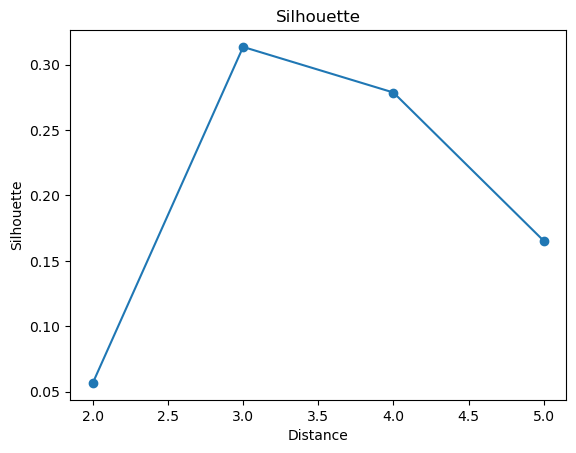

D'après l'indice de silhouette, nb clusters = 3 , nb feuilles =  6  runtime =  0.0 s 

-------------- Layer 4 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 5 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 6 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 7 -----------------


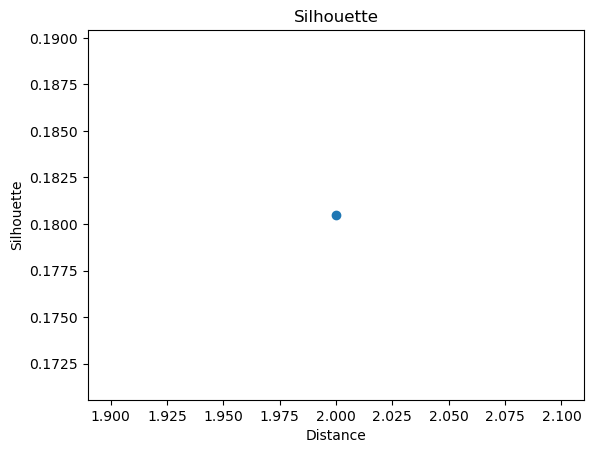

D'après l'indice de silhouette, nb clusters = 2 , nb feuilles =  3  runtime =  0.0 s 

-------------- Layer 8 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 9 -----------------


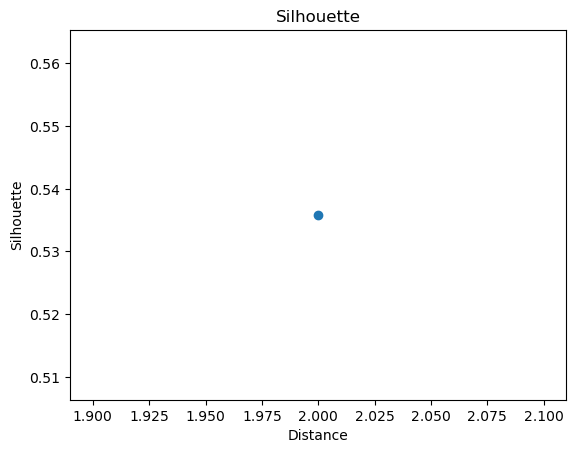

D'après l'indice de silhouette, nb clusters = 2 , nb feuilles =  3  runtime =  0.0009980201721191406 s 

-------------- Layer 10 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 11 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 

-------------- Layer 12 -----------------
Pas assez de données pour faire un clustering : On a juste  1  données
numbre de clusters =  1 



In [5]:
nb_clusters = []

for i in range(len(layers)):
    data = layers[i]
    print("-------------- Layer", i, "-----------------")
    # print(len(data))
    
    if len(data) > 2:
        list, k_max, leaves_max, runtime = cl.silhouette(data)
        nb_clusters.append(k_max)

        # print(len(data))
        print("D'après l'indice de silhouette, nb clusters =", k_max ,", nb feuilles = ", leaves_max , 
              " runtime = ", runtime ,"s \n")
        
    else:
        print("Pas assez de données pour faire un clustering : On a juste ", len(data), " données")
        print("numbre de clusters = ", len(data),"\n")
        nb_clusters.append(len(data))

In [6]:
# print(list_equal)
# print(len(matrix))
# cl.clustering(layers, 120, 200, 1)

In [10]:

for i in range(len(layers)):
    data = layers[i]
    if(len(data)==1):
        solver.add_constraint(solver.manhattan_distance(data[0], [ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >=3)
    
    k = nb_clusters[i]

    print("-------------- Layer", i, "-----------------")
    k , leaves , labels, runtime = cl.my_agglo_k(data, k, 'single')
    avg=[[0 for i in range(len(data))] for i in range(k)]
    card=[0 for i in range(k) ]
    for i in range(len(data)):
        card[labels[i]]+=1
        avg[labels[i]]=avg[labels[i]]+data[i]
    for i in range(k):
        avg[i]=[avg[i][k]/card[i] for k in range(len(avg[i]))]
    
    the_ones=[None for i in range(k)]
    for i in range(len(data)):
        if(the_ones[labels[i]]==None or solver.manhattan_distance(data[i],avg[labels[i]])<solver.manhattan_distance(the_ones[labels[i]],avg[labels[i]])):
                the_ones[labels[i]]=data[i]
    for i in range(k):
        solver.add_constraint(solver.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >=3)
    


IndentationError: expected an indented block after 'if' statement on line 3 (643294363.py, line 6)

In [14]:
l1 = [1,23,4]
l2 = [1,23,4]
l1np = np.array(l1)
l2np = np.array(l2)
print(solver.manhattan_distance(l1np,l2np))

<class 'NoneType'>
